<a href="https://colab.research.google.com/github/hrishipoola/moderna_garch_model/blob/main/GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moderna: Modeling Volatility with GARCH

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Collect Data
4. Specify & Fit Model
   <br>4a. Constant mean, normal distribution
   <br>4b. Constant mean, skewed t distribution
   <br>4c. AR mean, skewed t distribution
   <br>4d. EGARCH (asymmetric shocks)
   <br>4e. GJR-GARCH (asymmetric shocks)
5. Goodness of Fit (max likelihood, AIC, BIC)
6. Parameter Significance Testing
7. Standardized Residuals
   <br>7a. ACF Plot
   <br>7b. Ljung-Box Test
8. Rolling Window Forecast
   <br>8a. Fixed Window
   <br>8b. Expanding Window
9. Backtesting
10. Dynamic Value at Risk (VaR)
11. References 

## 1. Introduction

Today, we'll model and forecast Moderna (ticker: MRNA) equity volatility using generalized autoregressive conditional heteroskedacity[(GARCH)](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) in order to better manage investment and options risk. I was inspired by a recent [a16z interview](https://a16z.com/2020/12/18/moderna-covid-vaccine-mrna-technology/) with Moderna's CEO Stephane Bancel and a [Datacamp course](https://learn.datacamp.com/courses/garch-models-in-python). 

GARCH provides a more realistic, reliable model for volatility (risk) by incorporating the clustered, time-varying character of volatility. Periods of high or low volatility tend to persist - volatility is more likely to be high at time t if it was also high at time t-1. Rising prices tend to be accompanied with falling volatility (steady uptick) and falling prices tend to be accompanied with rising volatility (panic selling). GARCH(p,q) models variance as a weighted average of past residuals up to lag p and weighted average of variance up to lag q. For example, GARCH(1,1) states that variance of time t equals a constant, omega, plus alpha x residual squared of time t-1, plus beta x variance of time t-1:

$\sigma^2_t = \omega + \alpha * residual^2_{t-1} + \beta * \sigma^2_{t-1}$

$\alpha$ represents how volatility reacts to new information. The larger the $\alpha$, the larger the immediate impact expressed as residuals (prediction errors). For daily observations, $\alpha$ is typically between 0.5 (stable) to around 0.1 (jumpy). The larger the $\beta$, the longer the duration of the impact. $\beta$ is typically between 0.85 and 0.98. Taken together, volatility with high $\alpha$ and low $\beta$ tend to be more spiky. Key requirements are:

$\omega, \alpha, \beta$ are non-negative
<br>$\alpha + \beta < 1$ (mean-reverting)

In the long run, $\sigma = \omega / (1-\alpha - \beta)$

If our GARCH model is working well, it will account for all predictable components and its residuals will be uncorrelated (white noise).

We'll also take into account asymmetric shocks with GJR-GARCH and exponential GARCH (EGARCH), which include a conditional parameter for differing impact of bad and good news on volatility. For example, GJR-GARCH is represented as:

$\sigma^2_t = \omega + \alpha * residual^2_{t-1} + \gamma *I* residual^2_{t-1} +  \beta * \sigma^2_{t-1}$

The additional parameter $\gamma$ takes into account asymmetric shock, where I is an indicator function that equals 1 if the unconditional standard deviation is less than 0. A negative and significant $\gamma$ means bad news increases volatility more than good news of similar magnitude. A positive and significant $\gamma$ means that good news increases volatility more than bad news of the same magnitude. 

We'll specify and fit several models, check goodness of fit, select the optimal model, check parameters and standardized residuals, create a rolling window forecast, backtest, and quantify value at risk (VaR). Try it out on a company you're interested in! In a future post, we'll see how GARCH works with a portfolio. 

Volatility is only one piece of the puzzle. Next steps:
- Model expected returns separately by fitting an ARIMA model
- Run Monte Carlo simulations
- From those draws, generate a realistic high confidence band for future expected MRNA's returns


## 2. Install & Import Packages

In [ ]:
!pip install yfinance
!pip install pandas-datareader

# Import yfinance to make Yahoo Finance API call 
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns
from datetime import datetime
from functools import reduce 

# Import data reader to directly convert Yahoo Finance data into dataframe
from pandas_datareader import data as pdr

!pip install arch
from arch import arch_model

# ACF plot of standardized residuals
from statsmodels.graphics.tsaplots import plot_acf

# Ljunb-Box test of standardized residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set seaborn plot style
sns.set_style("darkgrid")

# Set matplotlib plot style
style.use("fivethirtyeight")

## 3. Collect data

This [article](https://www.tandfonline.com/doi/abs/10.1080/13518470500039436) recommends having at least 500 observations when working with a GARCH(1,1) model in order to avoid negative bias and convergence errors. 

In [ ]:
# Grab data from Yahoo Finance as dataframe
mrna = pdr.get_data_yahoo('MRNA', start='2018-12-03', end='2021-01-13')

# Check first 3 and last 3 rows
pd.concat([mrna.head(3), mrna.tail(3)])

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-07,22.750000,18.510000,22.000000,18.600000,12995600,18.600000
2018-12-10,19.438999,18.000000,18.900000,18.799999,4233300,18.799999
2018-12-11,20.660000,17.990000,20.549999,18.010000,3435300,18.010000
2021-01-11,121.239998,112.620003,112.750000,117.260002,16650600,117.260002
2021-01-12,124.910004,117.120003,117.930000,124.550003,15300700,124.550003
2021-01-13,127.580002,120.739998,123.699997,124.059998,14324600,124.059998


Text(2020-04-12 00:00:00, 174.86000061035156, 'Vaccine FDA EUA application')

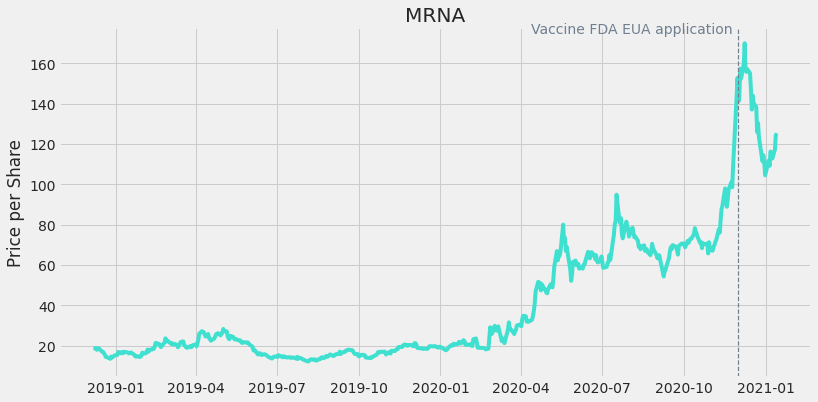

In [ ]:
# Keep only Adj Close column
mrna = mrna[['Adj Close']]

# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(mrna, color='turquoise')
ax.set(title='MRNA', ylabel='Price per Share') 

ax.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax.text(pd.to_datetime('2020-04-12'), max(mrna['Adj Close']+5), 'Vaccine FDA EUA application', color='slategray')

Text(2020-06-11 00:00:00, 27.81065106970553, 'Vaccine FDA EUA application')

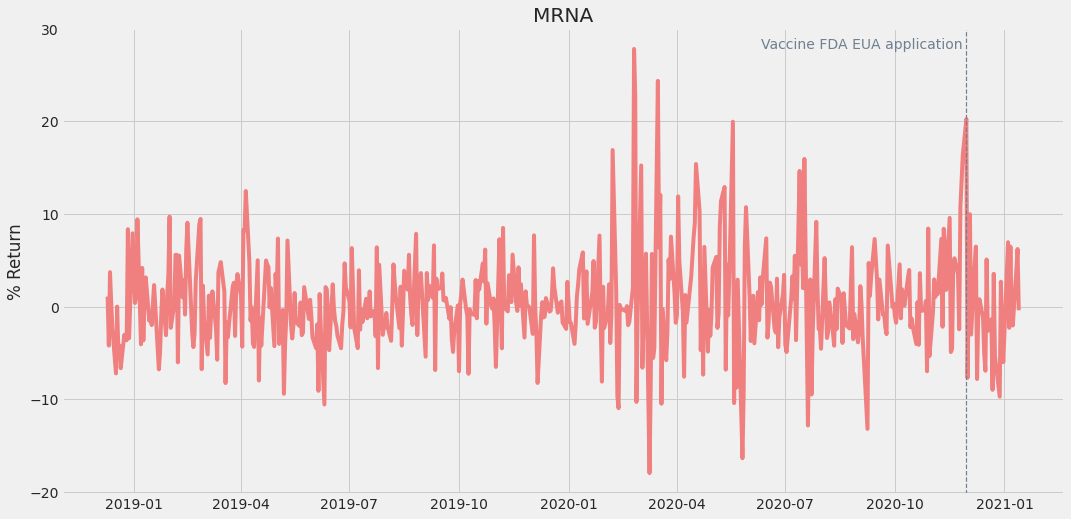

In [ ]:
mrna['return'] = mrna.pct_change().dropna() * 100

# Plot
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mrna['return'].dropna(), color='lightcoral')
ax.set(title='MRNA', ylabel='% Return') 

ax.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax.text(pd.to_datetime('2020-06-11'), max(mrna['return'].dropna()), 'Vaccine FDA EUA application', color='slategray')

MRNA returns show clear signs of clustering.

In [ ]:
# Make sure we drop nans
mrna.dropna(inplace=True)

daily_volatility = mrna['return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_trade_days = 21
monthly_volatility = np.sqrt(monthly_trade_days) * daily_volatility
print('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

yearly_trade_days = 252
yearly_volatility = np.sqrt(yearly_trade_days) * daily_volatility
print('Yearly volatility: ', '{:.2f}%'.format(yearly_volatility))

Daily volatility:  5.25%
Monthly volatility:  24.07%
Yearly volatility:  83.39%


3 steps to develop GARCH model
- Specify model (assumptions)
- Fit
- Forecast

Model assumptions
- distribution of residuals: normal, t, skewt
- mean model: constant, zero, AR
- volatility model: GARCH, ARCH, EGARCH

Fitting process finds paramaters for which the GARCH model is most likely to generate the observed time series data. 


## 4. Specify & Fit Model

## 4a. Constant mean, normal distribution

In [ ]:
basic_gm = arch_model(mrna['return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal') 
gm_result = basic_gm.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1584.7567718718024
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1583.8617515769297
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1583.2911385925936
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1583.1490696260444
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1583.0851306547793
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1583.0414436459055
Iteration:      7,   Func. Count:     51,   Neg. LLF: 1583.0354224972766
Iteration:      8,   Func. Count:     57,   Neg. LLF: 1583.0349788375886
Iteration:      9,   Func. Count:     63,   Neg. LLF: 1583.0349359229526
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1583.0349359228876
            Iterations: 9
            Function evaluations: 63
            Gradient evaluations: 9


In [ ]:
gm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -1583.03
Distribution:                  Normal   AIC:                           3174.07
Method:            Maximum Likelihood   BIC:                           3191.15
                                        No. Observations:                  528
Date:                Wed, Jan 20 2021   Df Residuals:                      524
Time:                        14:33:03   Df Model:                            4
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.3391      0.197      1.723  8.486e-02 [-4.661e-02,  0.725]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.1586      0.760      1.524      0.127   [ -0.331,  2.648]
alpha[1]       0.1090  3.516e-02      3.099  1.940e-03 [4.006e-02,  0.178]
beta[1]        0.8515  5.809e-02     14.659  1.179e-48   [  0.738,  0.965]
==========================================================================

Covariance estimator: robust
"""

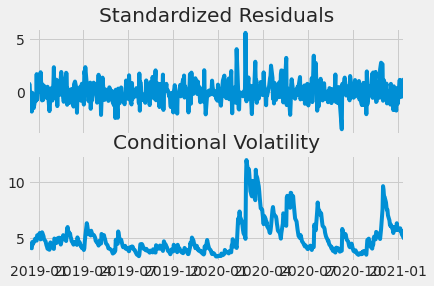

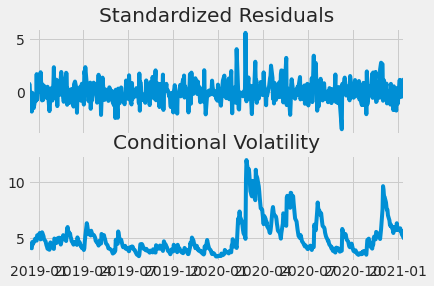

In [ ]:
gm_result.plot()

In [ ]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                  h.1        h.2        h.3        h.4        h.5
Date                                                             
2021-01-13  23.353193  23.589697  23.816862  24.035058  24.244639


[Text(0.5, 1.0, 'Distribution of Standardized Residuals')]

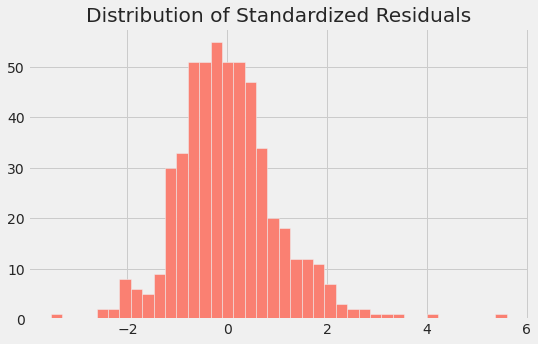

In [ ]:
# Calculate standardized residual
gm_std_resid = gm_result.resid / gm_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(gm_std_resid, color='salmon', bins=40)
ax.set(title='Distribution of Standardized Residuals')

The distribution of standardized residuals is closer to a t-distribution with fatter tails than normal and with positive skew. Let's try fitting with a skewt distribution below.




## 4b. Constant mean, skewed t distribution

In [ ]:
skewt_gm = arch_model(mrna['return'], p=1, q=1, mean='constant', vol='GARCH', dist='skewt') 
skewt_result = skewt_gm.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1570.2164348756803
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1566.6483855224474
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1565.6838157425577
Iteration:      4,   Func. Count:     37,   Neg. LLF: 1563.1125716541783
Iteration:      5,   Func. Count:     46,   Neg. LLF: 1561.123539279904
Iteration:      6,   Func. Count:     55,   Neg. LLF: 1560.7169913889754
Iteration:      7,   Func. Count:     64,   Neg. LLF: 1560.6847459584492
Iteration:      8,   Func. Count:     73,   Neg. LLF: 1560.5620933074908
Iteration:      9,   Func. Count:     81,   Neg. LLF: 1560.5236607809047
Iteration:     10,   Func. Count:     89,   Neg. LLF: 1560.5148152781717
Iteration:     11,   Func. Count:     97,   Neg. LLF: 1560.5090569194188
Iteration:     12,   Func. Count:    105,   Neg. LLF: 1560.5059198918623
Iteration:     13,   Func. Count:    113,   Neg. LLF: 1560.5046267922746
Iteration:     14,   Func. Count:    121,   Neg. LLF

In [ ]:
skewt_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                            return   R-squared:                      -0.001
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                                 GARCH   Log-Likelihood:               -1560.50
Distribution:      Standardized Skew Student's t   AIC:                           3133.01
Method:                       Maximum Likelihood   BIC:                           3158.62
                                                   No. Observations:                  528
Date:                           Wed, Jan 20 2021   Df Residuals:                      522
Time:                                   14:33:04   Df Model:                            6
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.3569      0.193      1.848  6.466e-02 [-2.170e-02,  0.735]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          2.7012      2.013      1.342      0.180   [ -1.243,  6.646]
alpha[1]       0.1549  6.830e-02      2.267  2.337e-02 [2.099e-02,  0.289]
beta[1]        0.7455      0.134      5.557  2.745e-08   [  0.483,  1.008]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu             6.0645      1.493      4.061  4.889e-05   [  3.137,  8.991]
lambda         0.2061  6.536e-02      3.153  1.615e-03 [7.799e-02,  0.334]
==========================================================================

Covariance estimator: robust
"""

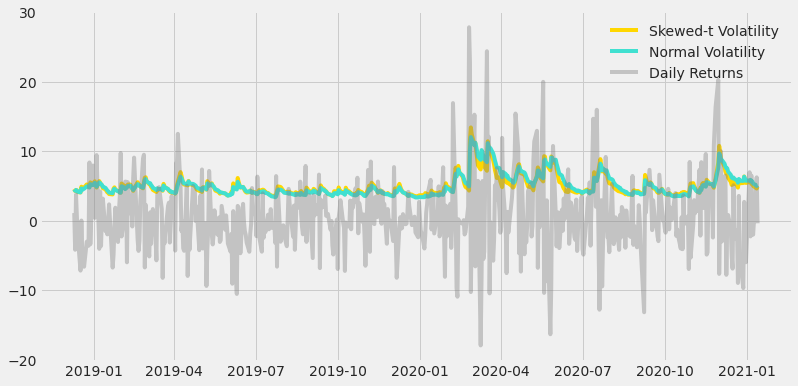

In [ ]:
# Get model estimated volatility
normal_volatility = gm_result.conditional_volatility
skewt_volatility = skewt_result.conditional_volatility

# Plot model fitting results
plt.figure(figsize=(12,6))
plt.plot(skewt_volatility, color = 'gold', label = 'Skewed-t Volatility')
plt.plot(normal_volatility, color = 'turquoise', label = 'Normal Volatility')
plt.plot(mrna['return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)

The gold skew-t plot begins to diverge more from the normal plot in March 2020. 

## 4c. Autoregressive (AR) Mean, skewed t distribution

In [ ]:
armean_gm = arch_model(mrna['return'], p=1, q=1, mean='AR', lags=1, vol='GARCH', dist='skewt') 
armean_result = armean_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 1568.3536285475734
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1567.0045646813383
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1564.22103942897
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1563.3122226100008
Iteration:      5,   Func. Count:     53,   Neg. LLF: 1560.0873992328143
Iteration:      6,   Func. Count:     63,   Neg. LLF: 1558.3125994753518
Iteration:      7,   Func. Count:     73,   Neg. LLF: 1558.2248758597752
Iteration:      8,   Func. Count:     83,   Neg. LLF: 1558.130635996679
Iteration:      9,   Func. Count:     93,   Neg. LLF: 1558.0344513052219
Iteration:     10,   Func. Count:    102,   Neg. LLF: 1557.993909539789
Iteration:     11,   Func. Count:    111,   Neg. LLF: 1557.9852203592677
Iteration:     12,   Func. Count:    120,   Neg. LLF: 1557.9761735153397
Iteration:     13,   Func. Count:    129,   Neg. LLF: 1557.9735772056576
Iteration:     14,   Func. Count:    138,   Neg. LLF: 1

In [ ]:
armean_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                
=========================================================================================
Dep. Variable:                            return   R-squared:                      -0.002
Mean Model:                                   AR   Adj. R-squared:                 -0.004
Vol Model:                                 GARCH   Log-Likelihood:               -1557.97
Distribution:      Standardized Skew Student's t   AIC:                           3129.95
Method:                       Maximum Likelihood   BIC:                           3159.82
                                                   No. Observations:                  527
Date:                           Wed, Jan 20 2021   Df Residuals:                      520
Time:                                   14:33:05   Df Model:                            7
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.3634      0.196      1.854  6.373e-02 [-2.075e-02,  0.748]
return[1]     -0.0112  4.800e-02     -0.233      0.816  [ -0.105,8.290e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          2.6248      2.039      1.287      0.198   [ -1.372,  6.622]
alpha[1]       0.1519  7.240e-02      2.098  3.588e-02 [1.001e-02,  0.294]
beta[1]        0.7509      0.139      5.408  6.369e-08   [  0.479,  1.023]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu             6.0545      1.520      3.983  6.811e-05   [  3.075,  9.034]
lambda         0.2093  6.409e-02      3.265  1.094e-03 [8.366e-02,  0.335]
==========================================================================

Covariance estimator: robust
"""

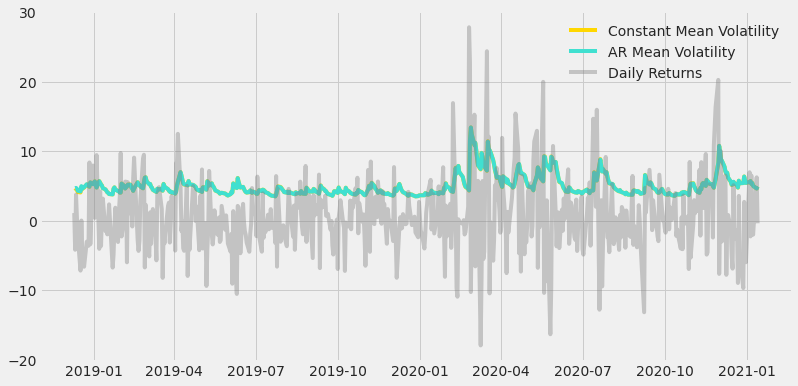

In [ ]:
armean_volatility = armean_result.conditional_volatility.dropna() # uses lag, first row will be NaN
skewt_volatility = skewt_volatility.iloc[1:] # drop first row

# Plot model fitting results
plt.figure(figsize=(12,6))
plt.plot(skewt_volatility, color = 'gold', label = 'Constant Mean Volatility')
plt.plot(armean_volatility, color = 'turquoise', label = 'AR Mean Volatility')
plt.plot(mrna['return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)

In [ ]:
# Correlation 
np.corrcoef(skewt_volatility, armean_volatility)[0,1]

0.9997786815373514

Correlation is close to 1 and both models look similar, we can assume the simplest specification for mean - constant mean.  

## 4d. EGARCH (asymmetric shock) 

So far we've assumed that positive and negative movements in return have the same (symmetric) impact on volatility. In reality, they often impact volatility asymmetrically with returns increasing gradually and falling sharply (as companies become more leveraged due to higher debt-to-equity ratio). GJR-GARCH and exponential GARCH (EGARCH) are volatility models for asymmetric shocks that include a conditional parameter (o = 1) for differing impact. 

In [ ]:
egarch_gm = arch_model(mrna['return'], p=1, q=1, o=1, mean='constant', vol='EGARCH', dist='skewt') 
egarch_result = egarch_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 1566.09857308538
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1565.9086920666894
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1565.79666986351
Iteration:      4,   Func. Count:     44,   Neg. LLF: 1565.0908092385794
Iteration:      5,   Func. Count:     55,   Neg. LLF: 1563.8552489797712
Iteration:      6,   Func. Count:     65,   Neg. LLF: 1560.9300011359956
Iteration:      7,   Func. Count:     75,   Neg. LLF: 1560.5913963900853
Iteration:      8,   Func. Count:     86,   Neg. LLF: 1560.4716213966772
Iteration:      9,   Func. Count:     96,   Neg. LLF: 1559.7649808225042
Iteration:     10,   Func. Count:    106,   Neg. LLF: 1559.7143169311894
Iteration:     11,   Func. Count:    115,   Neg. LLF: 1559.7023014252159
Iteration:     12,   Func. Count:    124,   Neg. LLF: 1559.6977847099865
Iteration:     13,   Func. Count:    133,   Neg. LLF: 1559.6973602408384
Iteration:     14,   Func. Count:    142,   Neg. LLF: 1

In [ ]:
egarch_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - EGARCH Model Results                          
=========================================================================================
Dep. Variable:                            return   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                                EGARCH   Log-Likelihood:               -1559.70
Distribution:      Standardized Skew Student's t   AIC:                           3133.39
Method:                       Maximum Likelihood   BIC:                           3163.28
                                                   No. Observations:                  528
Date:                           Wed, Jan 20 2021   Df Residuals:                      521
Time:                                   14:33:06   Df Model:                            7
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3830      0.195      1.965  4.945e-02 [9.218e-04,  0.765]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2280      0.249      0.915      0.360   [ -0.260,  0.716]
alpha[1]       0.1966      0.163      1.204      0.229   [ -0.123,  0.517]
gamma[1]       0.0808  3.167e-02      2.550  1.077e-02 [1.869e-02,  0.143]
beta[1]        0.9300  7.682e-02     12.107  9.714e-34   [  0.779,  1.081]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu             6.0121      1.477      4.071  4.684e-05   [  3.118,  8.907]
lambda         0.1880  6.487e-02      2.898  3.759e-03 [6.083e-02,  0.315]
==========================================================================

Covariance estimator: robust
"""

## 4e. GJR-GARCH

In [ ]:
gjrgarch_gm = arch_model(mrna['return'], p=1, q=1, o=1, mean='constant', vol='GARCH', dist='skewt') 
gjrgarch_result = gjrgarch_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 1570.8537218314987
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1565.7247587109223
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1564.816453866079
Iteration:      4,   Func. Count:     41,   Neg. LLF: 1561.3934757288976
Iteration:      5,   Func. Count:     52,   Neg. LLF: 1560.3752241762345
Iteration:      6,   Func. Count:     62,   Neg. LLF: 1560.1385694185058
Iteration:      7,   Func. Count:     72,   Neg. LLF: 1559.1948033793394
Iteration:      8,   Func. Count:     82,   Neg. LLF: 1558.4106336253208
Iteration:      9,   Func. Count:     93,   Neg. LLF: 1558.377241037572
Iteration:     10,   Func. Count:    102,   Neg. LLF: 1558.0661636289371
Iteration:     11,   Func. Count:    111,   Neg. LLF: 1557.7921673850556
Iteration:     12,   Func. Count:    120,   Neg. LLF: 1557.6034319422893
Iteration:     13,   Func. Count:    129,   Neg. LLF: 1557.5946997949627
Iteration:     14,   Func. Count:    138,   Neg. LLF:

In [ ]:
gjrgarch_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GJR-GARCH Model Results                         
=========================================================================================
Dep. Variable:                            return   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -1557.58
Distribution:      Standardized Skew Student's t   AIC:                           3129.16
Method:                       Maximum Likelihood   BIC:                           3159.05
                                                   No. Observations:                  528
Date:                           Wed, Jan 20 2021   Df Residuals:                      521
Time:                                   14:33:06   Df Model:                            7
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.4236      0.195      2.171  2.993e-02 [4.119e-02,  0.806]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.4930      2.152      0.694      0.488    [ -2.725,  5.710]
alpha[1]       0.1187      0.139      0.856      0.392    [ -0.153,  0.390]
gamma[1]      -0.1187  4.343e-02     -2.732  6.292e-03 [ -0.204,-3.353e-02]
beta[1]        0.8732      0.199      4.399  1.088e-05    [  0.484,  1.262]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu             6.3446      1.633      3.884  1.026e-04   [  3.143,  9.546]
lambda         0.2082  6.299e-02      3.305  9.494e-04 [8.473e-02,  0.332]
==========================================================================

Covariance estimator: robust
"""

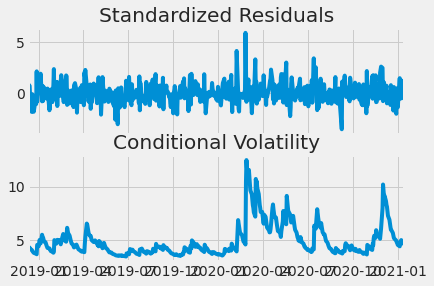

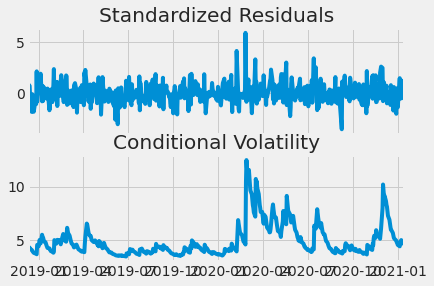

In [ ]:
gjrgarch_result.plot()

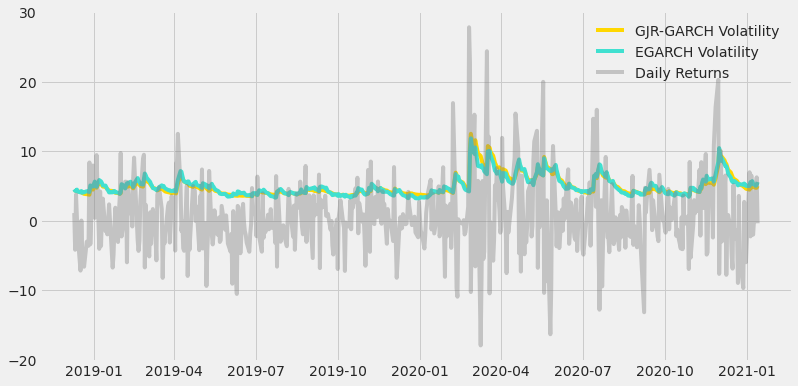

In [ ]:
# Get model estimated volatility
gjrgarch_volatility = gjrgarch_result.conditional_volatility
egarch_volatility = egarch_result.conditional_volatility

# Plot model fitting results
plt.figure(figsize=(12,6))
plt.plot(gjrgarch_volatility, color = 'gold', label = 'GJR-GARCH Volatility')
plt.plot(egarch_volatility, color = 'turquoise', label = 'EGARCH Volatility')
plt.plot(mrna['return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)

## 5. Goodness of Fit

1. Log Likelhood (maximize)
2. Information Criteria (AIC, BIC) (minimize)

Based on log likelihood, AIC, BIC below, GJR-GARCH is our best fitting model

In [ ]:
# Function to create dataframe of log likelihood, AIC, BIC for each model
def goodness_of_fit():
  global df
  model_names = ['normal', 'skewt', 'GJR-GARCH', 'EGARCH']
  models = [gm_result, skewt_result, gjrgarch_result, egarch_result]
  likelihood = [model.loglikelihood for model in models]
  aic = [model.aic for model in models]
  bic = [model.bic for model in models]
  dict = {'model':model_names, 'log likelihood':likelihood, 'aic':aic,'bic':bic}
  df = pd.DataFrame(dict).set_index('model')
  return df

goodness_of_fit()

,log likelihood,aic,bic
model,,,
normal,-1583.034936,3174.069872,3191.146257
skewt,-1560.504559,3133.009118,3158.623696
GJR-GARCH,-1557.581449,3129.162899,3159.046573
EGARCH,-1559.697247,3133.394495,3163.278169


In [ ]:
# Highlight max log likelihood
df.style.highlight_max(subset='log likelihood', color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-1583.034936,3174.069872,3191.146257
skewt,-1560.504559,3133.009118,3158.623696
GJR-GARCH,-1557.581449,3129.162899,3159.046573
EGARCH,-1559.697247,3133.394495,3163.278169


GJR-GARCH performs the best in terms of log likelihood.

In [ ]:
# Highlight min AIC, BIC
df.style.highlight_min(subset=['aic', 'bic'], color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-1583.034936,3174.069872,3191.146257
skewt,-1560.504559,3133.009118,3158.623696
GJR-GARCH,-1557.581449,3129.162899,3159.046573
EGARCH,-1559.697247,3133.394495,3163.278169


GJR-GARCH has the lowest AIC, while GJR-GARCH and skewed t have the lowest BIC. Based on this, let's select GJR-GARCH as our model.  

## 6. Parameter Significance Testing

Significance testing of parameters is one piece of understanding our model, but, in terms of variable selection, it should be taken with a grain of salt ([article](https://robjhyndman.com/hyndsight/tests2/)) - it's possible to have an insignificant coefficient for a variable that's useful for forecasting as well as having a significant variable that's better omitted for forecasting. We'll also look at residuals as well as AIC and BIC below. 




In [ ]:
# Get parameter stats from model summary
parameters = pd.DataFrame({'parameter': gjrgarch_result.params,
                           'p-value': gjrgarch_result.pvalues})

parameters

,parameter,p-value
mu,0.423589,0.029926
omega,1.492966,0.487797
alpha[1],0.118651,0.392264
gamma[1],-0.118651,0.006292
beta[1],0.873240,0.000011
nu,6.344646,0.000103
lambda,0.208200,0.000949


The high $\alpha$ indicates a large immediate impact on residuals, while the relatively high $\beta$ indicates a persisting impact. The negative $\gamma$ implies that bad news increases volatility more than good news of similar magnitude. From the significance test, omega and alpha aren't significant (p-values above 0.05). However, we should be [careful about removing them](https://stats.stackexchange.com/questions/202493/should-i-keep-a-non-significant-intercept-in-a-garch-model) based on this. 




## 7. Standardized Residuals

[Text(0.5, 1.0, 'Standardized Resduals')]

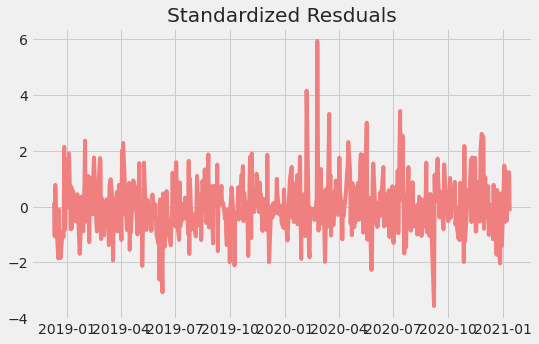

In [ ]:
# Calculate standardized residual
gjrgarch_std_resid = gjrgarch_result.resid / gjrgarch_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(gjrgarch_std_resid, color='lightcoral')
ax.set(title='Standardized Resduals') 

Autocorrelation tests randomness in standardized residuals for each lag and any significant autocorrelation in standardized residuals means the model may not be sound.

## 7a. ACF Plot

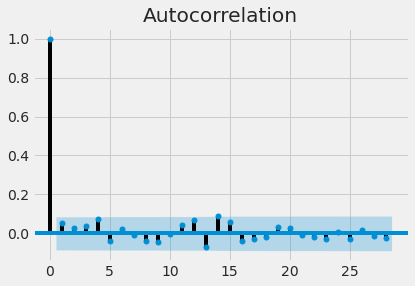

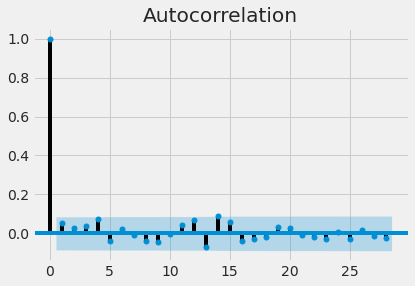

In [ ]:
plot_acf(gjrgarch_std_resid, alpha=0.05)

The ACF plots illustrate that there aren't any significant autocorrelations between residuals so the residuals represent white noise.

## 7b. Ljung-Box Test

Ljung-Box tests for overall randomness of standardized residuals. The null hypothesis is that the data is independently distributed. P-values <5% means the residuals aren't independently distributed and the model isn't sound. 


In [ ]:
# Ljung-Box test
lb_test = acorr_ljungbox(gjrgarch_std_resid, lags=10)

# P-values dataframe, transpose to get lags as columns
p_values = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = p_values.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
p_values.columns = col_names
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
P-values,0.224594,0.40569,0.472723,0.262924,0.297331,0.383427,0.492129,0.498922,0.494702,0.589821


All the p-values are above 5% meaning the null hypothesis can't be rejected and the standardized residuals are independently distributed. 

## 8. Rolling Window Forecast

To avoid lookback bias and be more responsive to recent events, let's create rolling window forecasts with both fixed and expanding windows. When setting the window size, too large a window may include obsolete data while too small a window might exclude relevant information (and increase variance). As we have a bit over 500 trading days in our data set and we've seen dramatic recent macro shifts and events related to vaccine development, we'll set the start location going back half a year, the window size to 60 trading days, and the forecast period to 30 days.   

## 8a. Fixed Window

Text(0.5, 1.0, 'MRNA Forecast Variance vs. Returns (Fixed Window)')

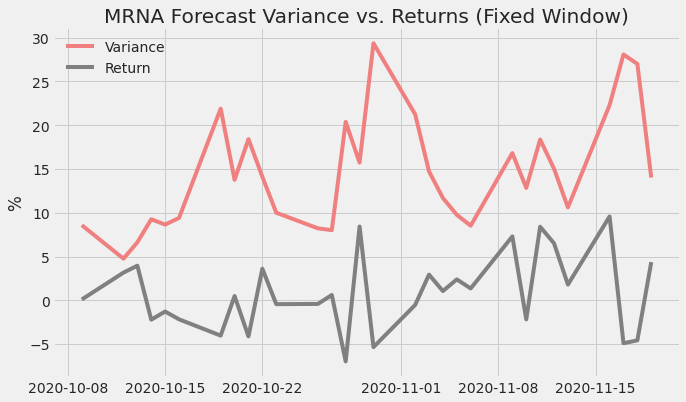

In [ ]:
# Start location set to going back with a half year of trading days
start_loc = len(mrna) - round(0.5 * yearly_trade_days)

# Window of 60 days
end_loc = start_loc + 60

forecasts={}

for i in range(30):

    # Fit with fixed rolling window
    gjrgarch_fixed_rolling_result = gjrgarch_gm.fit(first_obs = i + start_loc, 
                                              last_obs = i + end_loc, 
                                              update_freq = 5,
                                              disp='off')
    
    # 1-period variance forecast and save the result
    temp_result = gjrgarch_fixed_rolling_result.forecast(horizon = 1).variance
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast

# Create dataframe, transpose to get dates as rows and variance as column     
forecast_var_fixed = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.figure(figsize=(10,6))
plt.plot(forecast_var_fixed, color = 'lightcoral', label='Variance')
plt.plot(mrna.iloc[start_loc+60:end_loc+30]['return'], color = 'gray', label='Return')
plt.ylabel('%')
plt.legend(frameon=False)
plt.title('MRNA Forecast Variance vs. Returns (Fixed Window)')

Model does a fairly good job as variance seems to fluctuate with returns. 

## 8b. Expanding Window

Text(0.5, 1.0, 'MRNA Forecast Variance vs. Returns (Expanding Window)')

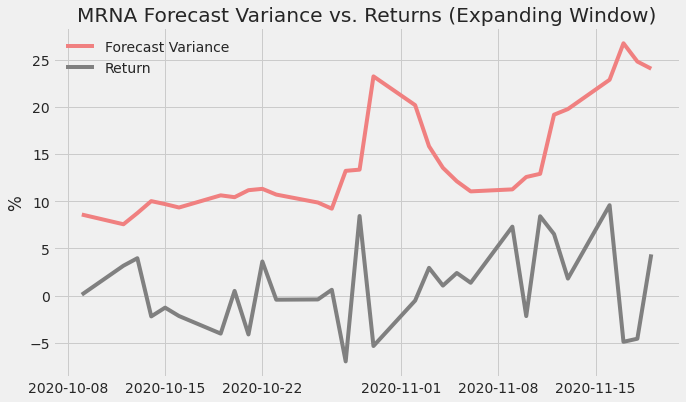

In [ ]:
# Start location set to going back with a half year of trading days
start_loc = len(mrna) - round(0.5 * yearly_trade_days)

# Window of 60 days
end_loc = start_loc + 60

forecasts={}

for i in range(30):

    # Fit with fixed rolling window
    gjrgarch_expanding_rolling_result = gjrgarch_gm.fit(first_obs = start_loc, 
                                              last_obs = i + end_loc, 
                                              update_freq = 5,
                                              disp='off')
    
    # 1-period variance forecast and save the result
    temp_result_expanding = gjrgarch_expanding_rolling_result.forecast(horizon = 1).variance
    fcast = temp_result_expanding.iloc[i + end_loc]
    forecasts[fcast.name] = fcast

# Create dataframe, transpose to get dates as rows and variance as column     
forecast_var_expanding = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.figure(figsize=(10,6))
plt.plot(forecast_var_expanding, color = 'lightcoral', label='Forecast Variance')
plt.plot(mrna.iloc[start_loc+60:end_loc+30]['return'], color = 'gray', label='Return')
plt.ylabel('%')
plt.legend(frameon=False)
plt.title('MRNA Forecast Variance vs. Returns (Expanding Window)')

The expanding window doesn't seem to do as good a job in the beginning of the forecast period as with the fixed window.

Text(0.5, 1.0, 'MRNA Forecast Variance vs. Returns')

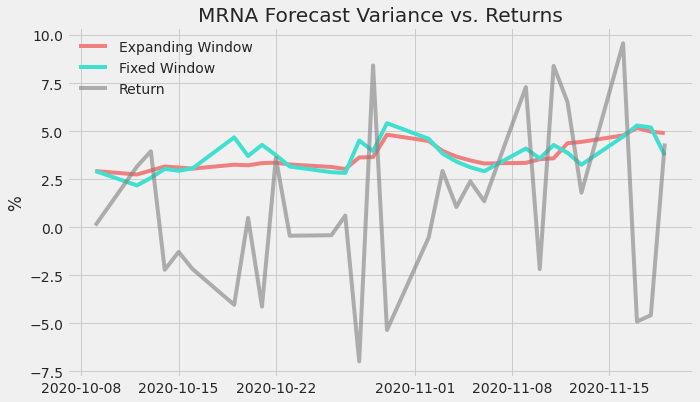

In [ ]:
# Calculate volatility for fixed and expanding windows
fixed_window_volatility = np.sqrt(forecast_var_fixed)
expanding_window_volatility = np.sqrt(forecast_var_expanding)

# Plot volatility for fixed and expanding windows
plt.figure(figsize=(10,6))
plt.plot(expanding_window_volatility, color = 'lightcoral', label='Expanding Window')
plt.plot(fixed_window_volatility, color = 'turquoise', label='Fixed Window')
plt.plot(mrna['return']['2020-10-09':'2020-11-19'], color = 'gray', alpha=0.6, label='Return')
plt.ylabel('%')
plt.legend(frameon=False)
plt.title('MRNA Forecast Variance vs. Returns')

The fixed window forecast shows more volatility (more conservative) than the expanding window forecast.  

## 9. Backtesting

In [ ]:
# Variance from model
actual_var = gjrgarch_result.conditional_volatility ** 2 
actual_var = actual_var['2020-10-09':'2020-11-19']

# Convert actual and forecast variance to numpy arrays
actual_var, forecast_var_fixed = np.array(actual_var), np.array(forecast_var_fixed)

def evaluate(observation, forecast): 

    # MAE
    mae = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
   
    # MSE
    mse = mean_squared_error(observation, forecast)
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))

    # MAPE: not in scikitlearn, let's calculate it ourselves
    mape = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(mape))
    
    return mae, mse, mape

# Backtest model with MAE, MSE
evaluate(actual_var, forecast_var_fixed)

Mean Absolute Error (MAE): 6.68
Mean Squared Error (MSE): 61.7
Mean Absolute Percentage Error (MAPE): 39.4


(6.684961230372605, 61.70618454247694, 39.39715785360993)

MAPE of 39.4% is still quite high. In the future, we could try to improve model performance by adjusting forecast rolling window, model selection, and model parameters. 

## 10. Dynamic Value at Risk (VaR)

Since value at risk (VaR) is forward-looking, we'll generate a forecast and grab the forward-looking mean and volatility. There are 2 ways to calculate dynamic VaR: 

1. Parametric VaR: assumed distribution of standardized residuals
2. Empirical VaR: observed distribution of standardized residuals

In [ ]:
# Check our GJR-GARCH params - we'll use degrees of freedom (nu) and skew (lambda) for our VaR
gjrgarch_result.params

mu          0.423589
omega       1.492966
alpha[1]    0.118651
gamma[1]   -0.118651
beta[1]     0.873240
nu          6.344646
lambda      0.208200
Name: params, dtype: float64

5% parametric quantile:  -1.4440611931535732
5% empirical quantile:  -1.4168462857625845


Text(0.5, 1.0, 'MRNA VaR')

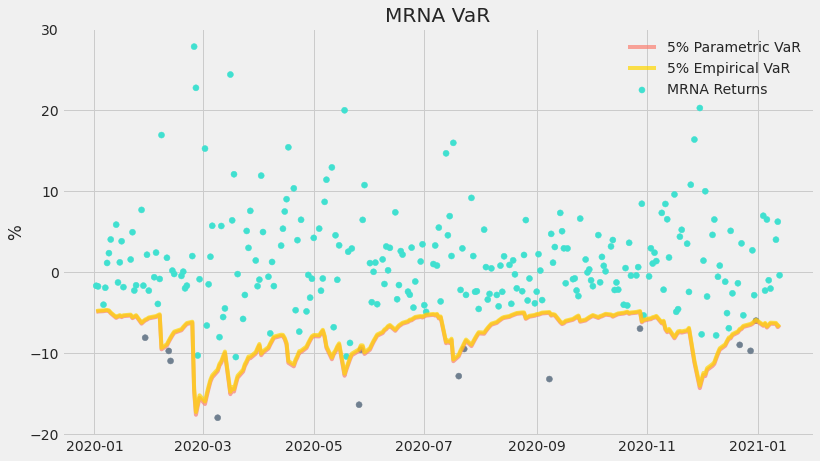

In [ ]:
# t distribution degrees of freedom (nu)
nu = gjrgarch_result.params[5]

# t distribution skew (lambda)
lam = gjrgarch_result.params[6]

# Forecast from 2020-01-01 onward 
gjrgarch_forecast = gjrgarch_result.forecast(start='2020-01-01')

# Forecast mean and variance 
mean_forecast = gjrgarch_forecast.mean['2020-01-01':]
variance_forecast = gjrgarch_forecast.variance['2020-01-01':]

# Parametric quantile, 2nd argument of .ppf must be in an array form
q_parametric = gjrgarch_gm.distribution.ppf(0.05, [nu, lam])
print('5% parametric quantile: ', q_parametric)

# Parametric VaR
VaR_parametric = mean_forecast.values + np.sqrt(variance_forecast).values * q_parametric
VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index = variance_forecast.index)

# Empirical quantile
q_empirical = gjrgarch_std_resid.quantile(0.05)
print('5% empirical quantile: ', q_empirical)

# Emperical VaR
VaR_empirical = mean_forecast.values + np.sqrt(variance_forecast).values * q_empirical
VaR_empirical = pd.DataFrame(VaR_empirical, columns = ['5%'], index = variance_forecast.index)

# Plot
plt.figure(figsize=(12,7))
plt.plot(VaR_parametric, color = 'salmon', label = '5% Parametric VaR', alpha=0.7)
plt.plot(VaR_empirical, color = 'gold', label = '5% Empirical VaR', alpha=0.7)
colors = np.where(mrna['return']['2020-01-01':] < VaR_empirical['5%'],'slategray','turquoise') # where return<VaR, point is dark red
plt.scatter(variance_forecast.index, mrna['return']['2020-01-01':], color = colors, label = 'MRNA Returns')
plt.legend(loc = 'upper right', frameon=False)
plt.ylabel('%')
plt.title('MRNA VaR')


The parametric and empircal VaR are similar. The GJR-GARCH model looks like it's doing a pretty good job as fewer than 5% of the returns (in red) fall below the VaR threshold (VaR exceedence), which is our risk limit. More than 5% points falling below the threshold would mean our model is underestimating risk. The lower the VaR threshold line, the larger the model's loss estimates (more conservative).

Interestingly, as we'd expect with Moderna, VaR is lowest at the start of the the 1st major lockdown in the U.S. and when the company applied for FDA EUA for its covid vaccine, as well as key moments in vaccine development. 


Text(2020-08-17 00:00:00, 169.86000061035156, 'Vaccine FDA EUA application')

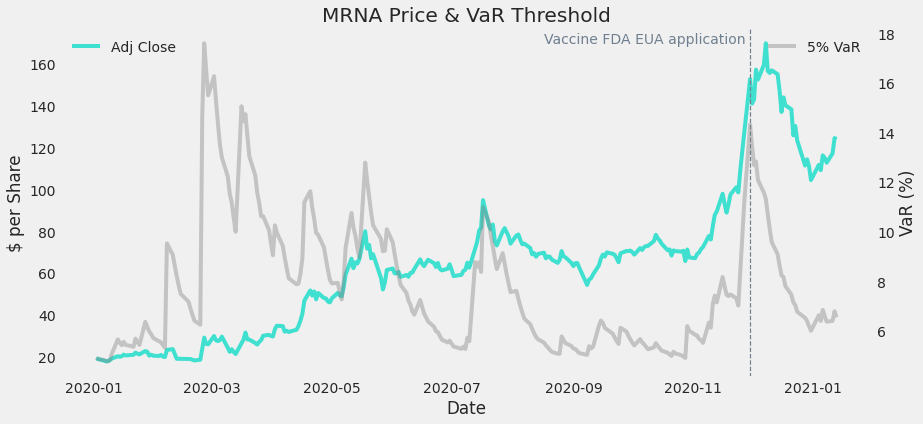

In [ ]:
fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)

VaR_parametric = -VaR_parametric 
ax1.plot(mrna.loc[VaR_parametric.index[0]:].index, mrna.loc[VaR_parametric.index[0]:]['Adj Close'], color='turquoise', label='Adj Close')
ax2.plot(VaR_parametric['5%'].index, VaR_parametric['5%'], color='grey', label='5% VaR', alpha=0.4)

ax1.set(title='MRNA Price & VaR Threshold', xlabel='Date',ylabel='$ per Share')
ax2.set(ylabel='VaR (%)')
ax1.legend(loc='upper left', frameon=False)
ax2.legend(frameon=False)

ax1.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax1.text(pd.to_datetime('2020-08-17'), max(mrna['Adj Close']), 'Vaccine FDA EUA application', color='slategray')

Similarly to the above chart, the VaR threshold peaks at the start of the 1st major lockdown in the U.S. and at vaccine FDA EUA application. In the past year, the VaR threshold increased, as expected, during key events and with increasing return. 

## 11. References

https://learn.datacamp.com/courses/garch-models-in-python

https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/

https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/

https://pyflux.readthedocs.io/en/latest/garch.html

https://www.tandfonline.com/doi/abs/10.1080/13518470500039436

https://stats.stackexchange.com/questions/175400/optimal-lag-order-selection-for-a-garch-model

https://stats.stackexchange.com/questions/136267/maximum-likelihood-in-the-gjr-garch1-1-model?noredirect=1&lq=1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

https://www.amazon.de/Market-Risk-Analysis-Financial-Instruments/dp/B009NNW5A8

https://stats.stackexchange.com/questions/246113/what-to-do-with-an-insignificant-intercept-in-a-garch-model

https://stats.stackexchange.com/questions/202493/should-i-keep-a-non-significant-intercept-in-a-garch-model

https://vlab.stern.nyu.edu/docs/volatility/GJR-GARCH

